# V&V Delivery Facility Choice Model

## Setup

In [1]:
import pandas as pd, numpy as np, os
from vivarium import Artifact
import db_queries
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

In [3]:
locations = ['Pakistan', 'Ethiopia', 'Nigeria']

In [4]:
# Parameters cell for papermill
model_dir = "model27.0"

In [5]:
# Parameters
model_dir = "model28.0"


In [6]:
base_results_dir = Path("/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/") / model_dir

In [7]:
results_dirs = {}
assert set([p.stem for p in base_results_dir.iterdir()]) == set([l.lower() for l in locations])
for location in locations:
    location_dir = base_results_dir / location.lower()
    timestamps = sorted(location_dir.iterdir())
    last_timestamp = timestamps[-1]
    if len(timestamps) > 1:
        print(f'Multiple timestamps: {timestamps}, using {last_timestamp}')
    results_dirs[location] = location_dir / last_timestamp / 'results'

results_dirs

{'Pakistan': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model28.0/pakistan/2026_01_22_10_48_48/results'),
 'Ethiopia': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model28.0/ethiopia/2026_01_22_10_43_03/results'),
 'Nigeria': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model28.0/nigeria/2026_01_22_10_46_09/results')}

In [8]:
location_ids = db_queries.get_ids('location')
location_ids = location_ids.loc[location_ids.location_name.str.lower().isin([x.lower() for x in results_dirs.keys()])]
location_ids

,location_id,location_name,location_type,location_description
139,165,Pakistan,admin0,admin0
150,179,Ethiopia,admin0,admin0
183,214,Nigeria,admin0,admin0


In [9]:
def load_yaml_file(path):
    with open(path) as stream:
        return yaml.safe_load(stream)

In [10]:
artifact_paths = {
    location: load_yaml_file(result_dir.parent / 'model_specification.yaml')['configuration']['input_data']['artifact_path']
    for location, result_dir
    in results_dirs.items()
}
artifact_paths

{'Pakistan': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/pakistan.hdf',
 'Ethiopia': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/ethiopia.hdf',
 'Nigeria': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/nigeria.hdf'}

In [11]:
def read_artifact(key, filter_terms=['sex == Female' , 'age_start > 5', 'age_end < 60']):
    all_locations_data = []
    for location in locations:
        art = Artifact(artifact_paths[location], filter_terms=filter_terms)
        location_data = art.load(key)
        if not isinstance(location_data, pd.DataFrame):
            location_data = pd.DataFrame({'value': location_data, 'location': location}, index=[0]).set_index('location')
        else:
            location_data['location'] = location
            location_data = location_data.reset_index().set_index(['location'] + [c for c in location_data.index.names if c is not None])
        all_locations_data.append(location_data)

    all_locations_data = pd.concat(all_locations_data)
    # FIXME: Check for draw columns comprehensively, rather than only in the first column
    if 'draw' in all_locations_data.columns[0]:
        all_locations_data = all_locations_data[[f'draw_{draw}' for draw in draws]]
    else:
        # TODO: Add an assert here about how the dataframe should look
        for draw in draws:
            all_locations_data[f'draw_{draw}'] = all_locations_data['value']
        all_locations_data = all_locations_data.drop(columns='value')
    return all_locations_data

In [12]:
# TODO: Rename this variable to make clearer that it is Ethiopia only
art = Artifact(artifact_paths['Ethiopia'])
keys = art.keys

In [13]:
from vivarium_gates_mncnh.data.utilities import get_facility_choice_validation_targets

targets = get_facility_choice_validation_targets()
targets.head()

/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_artifact/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


,probability_of,Ethiopia,Nigeria,Pakistan
0,in_facility_given_anc0,0.183369,0.309069,0.556322
1,in_facility_given_anc1,0.664786,0.584168,0.795407
2,preterm_given_at_home,0.163579,0.172663,0.194529
3,preterm_given_in_facility,0.163486,0.153000,0.155164
4,male,0.515312,0.512450,0.519811


In [14]:
def read_results(result_file_name, baseline_only=True):
    all_locations_results = []
    for location, result_dir in results_dirs.items():
        location_results = pd.read_parquet(result_dir / f'{result_file_name}.parquet').drop(columns=['measure','entity','sub_entity','entity_type'])
        location_results['location'] = location
        if 'scenario' not in location_results.columns:
            location_results['scenario'] = 'baseline'
        if baseline_only:
            location_results = location_results.loc[location_results.scenario == 'baseline']

        # Aggregate over random seeds (if necessary)
        # TODO: Could use vivarium_helpers marginalize method here
        if 'random_seed' in location_results.columns:
            location_results = location_results.groupby([
                c for c in location_results.columns if c != 'random_seed' and c != 'value'
            ]).sum().reset_index().drop(columns='random_seed')

        all_locations_results.append(location_results)
    return pd.concat(all_locations_results, ignore_index=True)

In [15]:
# TODO: Clarify this observer name -- why is it called this? What does it match in the docs?
# TODO: Give this a more descriptive name than `data`
data = read_results('anc_other', baseline_only=True)
draws = data.input_draw.unique()
data

,acs_availability,acs_eligibility,age_group,anc_coverage,azithromycin_availability,believed_preterm,delivery_facility_type,misoprostol_availability,pregnancy_outcome,preterm_birth,ultrasound_type,scenario,input_draw,location,value
0,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,22,Pakistan,0.0
1,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,60,Pakistan,0.0
2,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,71,Pakistan,0.0
3,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,79,Pakistan,0.0
4,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,115,Pakistan,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976635,True,True,95_plus,none,True,True,none,True,stillbirth,True,standard,baseline,118,Nigeria,0.0
4976636,True,True,95_plus,none,True,True,none,True,stillbirth,True,standard,baseline,146,Nigeria,0.0
4976637,True,True,95_plus,none,True,True,none,True,stillbirth,True,standard,baseline,167,Nigeria,0.0
4976638,True,True,95_plus,none,True,True,none,True,stillbirth,True,standard,baseline,197,Nigeria,0.0


In [16]:
# NOTE: It looks like the only thing we're missing from the previous observer is child sex,
# which is why we need this one. We should deduplicate.
births_df = read_results('births', baseline_only=True)
births_df

,acs_availability,acs_eligibility,antibiotics_availability,child_sex,cpap_availability,delivery_facility_type,pregnancy_outcome,preterm_birth,probiotics_availability,scenario,input_draw,location,value
0,False,False,False,Female,False,BEmONC,live_birth,False,False,baseline,22,Pakistan,40518.0
1,False,False,False,Female,False,BEmONC,live_birth,False,False,baseline,60,Pakistan,38265.0
2,False,False,False,Female,False,BEmONC,live_birth,False,False,baseline,71,Pakistan,38369.0
3,False,False,False,Female,False,BEmONC,live_birth,False,False,baseline,79,Pakistan,40571.0
4,False,False,False,Female,False,BEmONC,live_birth,False,False,baseline,115,Pakistan,40218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46075,True,True,True,Male,True,none,stillbirth,True,True,baseline,118,Nigeria,0.0
46076,True,True,True,Male,True,none,stillbirth,True,True,baseline,146,Nigeria,0.0
46077,True,True,True,Male,True,none,stillbirth,True,True,baseline,167,Nigeria,0.0
46078,True,True,True,Male,True,none,stillbirth,True,True,baseline,197,Nigeria,0.0


In [17]:
# TODO: Give this a more descriptive name than `df`
# clean dataframe
df = data.copy()
df = df.loc[df.pregnancy_outcome.isin(['live_birth', 'stillbirth'])] # eliminate "other" birth outcomes
assert df.loc[df.delivery_facility_type == 'none']['value'].sum() == 0, "Unexpected presence of delivery facility == 'none'"
df = df.loc[df.delivery_facility_type != 'none'] # get rid of these rows because they are not relevant
# add in columns for ANC1 and IFD
df['anc1'] = df.anc_coverage != 'none'
df['ifd'] = df.delivery_facility_type != 'home'
df

,acs_availability,acs_eligibility,age_group,anc_coverage,azithromycin_availability,believed_preterm,delivery_facility_type,misoprostol_availability,pregnancy_outcome,preterm_birth,ultrasound_type,scenario,input_draw,location,value,anc1,ifd
0,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,22,Pakistan,0.0,True,True
1,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,60,Pakistan,0.0,True,True
2,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,71,Pakistan,0.0,True,True
3,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,79,Pakistan,0.0,True,True
4,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,baseline,115,Pakistan,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976275,True,True,95_plus,none,True,True,home,True,stillbirth,True,standard,baseline,118,Nigeria,0.0,False,False
4976276,True,True,95_plus,none,True,True,home,True,stillbirth,True,standard,baseline,146,Nigeria,0.0,False,False
4976277,True,True,95_plus,none,True,True,home,True,stillbirth,True,standard,baseline,167,Nigeria,0.0,False,False
4976278,True,True,95_plus,none,True,True,home,True,stillbirth,True,standard,baseline,197,Nigeria,0.0,False,False


## Univariate checks


**Baseline in-facility delivery proption compared to GBD covariate ID 51**

In [18]:
# NOTE: I think there is a vivarium_helpers method for this
baseline_ifd = (df.groupby(['input_draw','location','ifd'])['value'].sum()
                / df.groupby(['input_draw','location'])['value'].sum())
baseline_ifd = baseline_ifd.groupby(['location','ifd']).describe(percentiles=[0.025,0.975]).reset_index()
baseline_ifd = baseline_ifd.loc[baseline_ifd.ifd]
baseline_ifd

,location,ifd,count,mean,std,min,2.5%,50%,97.5%,max
1,Ethiopia,True,10.0,0.562211,0.000551,0.561436,0.561447,0.562249,0.562972,0.563008
3,Nigeria,True,10.0,0.516442,0.001051,0.514949,0.514994,0.516381,0.518192,0.518350
5,Pakistan,True,10.0,0.781286,0.000331,0.780605,0.780704,0.781297,0.781805,0.781879


In [19]:
def return_target_data(value):
    return targets.loc[targets.probability_of == value].set_index('probability_of').rename_axis('location', axis=1).unstack().rename('target_value').reset_index()

target_ifd = return_target_data('in_facility')
target_ifd

,location,probability_of,target_value
0,Ethiopia,in_facility,0.558927
1,Nigeria,in_facility,0.513467
2,Pakistan,in_facility,0.777256


In [20]:
ifd_plot_data = (target_ifd
                 .merge(baseline_ifd, on='location'))
ifd_plot_data


,location,probability_of,target_value,ifd,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,in_facility,0.558927,True,10.0,0.562211,0.000551,0.561436,0.561447,0.562249,0.562972,0.563008
1,Nigeria,in_facility,0.513467,True,10.0,0.516442,0.001051,0.514949,0.514994,0.516381,0.518192,0.518350
2,Pakistan,in_facility,0.777256,True,10.0,0.781286,0.000331,0.780605,0.780704,0.781297,0.781805,0.781879


In [21]:
def plot_proportion_by_location(data):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Bar positions
    x = np.arange(len(data['location']))
    width = 0.35

    # Plot bars
    ax.bar(x - width/2, data['target_value'], width, label='Target')
    if 'mean' not in data.columns:
        data['mean'] = data['value']
    ax.bar(x + width/2, data['mean'], width, label='Simulation')

    # X-axis labels and ticks
    ax.set_xticks(x)
    ax.set_xticklabels(data['location'])
    ax.set_ylabel(data.probability_of.values[0])
    ax.set_title(f'Target vs Simulation {data.probability_of.values[0]} by Location')
    ax.legend()
    ax.errorbar(x + width/2, data['mean'],
                yerr=[data['mean'] - data['2.5%'], 
                    data['97.5%'] - data['mean']],
                fmt='none', ecolor='gray', capsize=5)
    plt.grid()
    plt.tight_layout()
    plt.show()

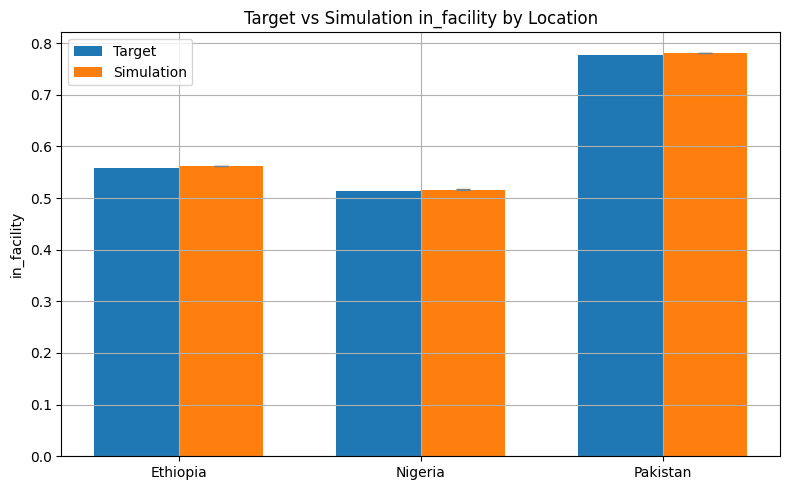

In [22]:
plot_proportion_by_location(ifd_plot_data)

# looks good, maybe a tiny bit high

In [23]:
# check the BEMONC/CEMONC split
baseline_bemonc_frac = (df.loc[df.delivery_facility_type == 'BEmONC'].groupby(['input_draw','location'])['value'].sum()
                        / df.loc[df.ifd].groupby(['input_draw','location'])['value'].sum())
baseline_bemonc_frac = baseline_bemonc_frac.groupby('location').mean().sort_index()
baseline_bemonc_frac

location
Ethiopia    0.295015
Nigeria     0.464505
Pakistan    0.781585
Name: value, dtype: float64

In [24]:
# TODO: Use `keys` variable
[x for x in art.keys if 'facility_choice' in x]

['cause.facility_choice.probability_home_birth',
 'cause.facility_choice.probability_bemonc_birth',
 'cause.facility_choice.probability_cemonc_birth',
 'cause.facility_choice.probability_home_birth_given_preterm',
 'cause.facility_choice.probability_home_birth_given_full_term',
 'cause.facility_choice.bemonc_facility_fraction']

In [25]:
target_bemonc_frac = read_artifact('cause.facility_choice.bemonc_facility_fraction').mean(axis=1).sort_index()
# note no draw-level variation

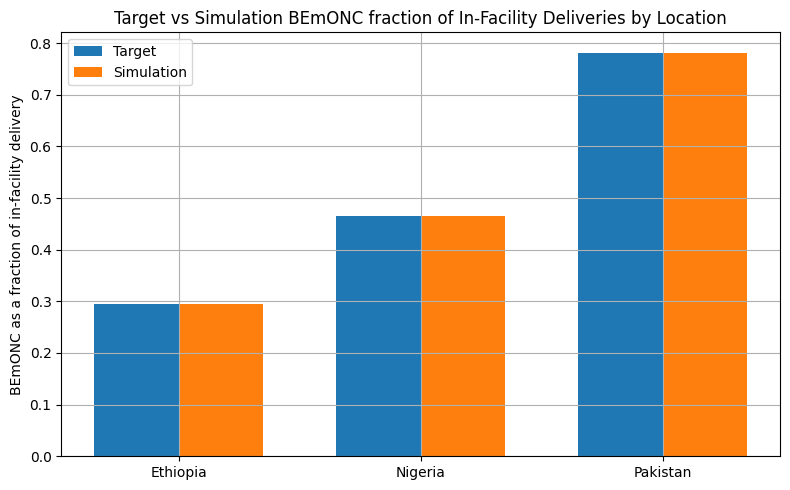

In [26]:
# TODO: refactor for duplication with the above
fig, ax = plt.subplots(figsize=(8, 5))

# Bar positions
x = np.arange(len(baseline_bemonc_frac))
width = 0.35

# Plot bars
ax.bar(x - width/2, target_bemonc_frac, width, label='Target')
ax.bar(x + width/2, baseline_bemonc_frac, width, label='Simulation')

# X-axis labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(baseline_bemonc_frac.index)
ax.set_ylabel('BEmONC as a fraction of in-facility delivery')
ax.set_title(f'Target vs Simulation BEmONC fraction of In-Facility Deliveries by Location')
ax.legend()

plt.grid()
plt.tight_layout()
plt.show()

# BEmONC/CEmONC split still looking good

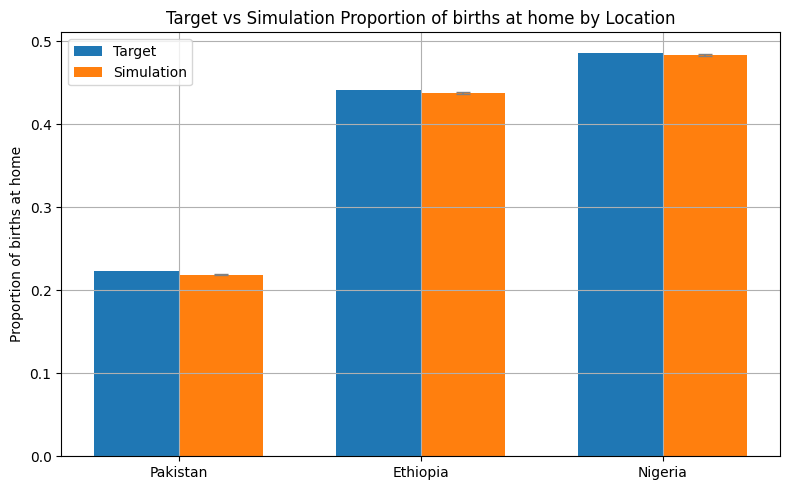

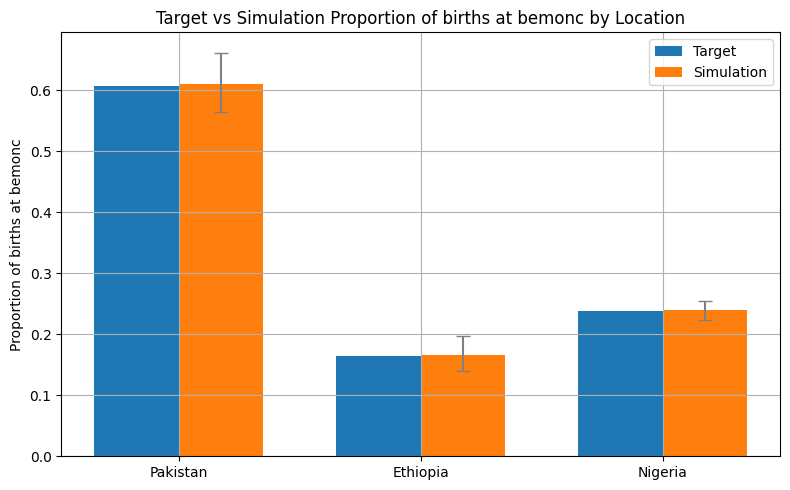

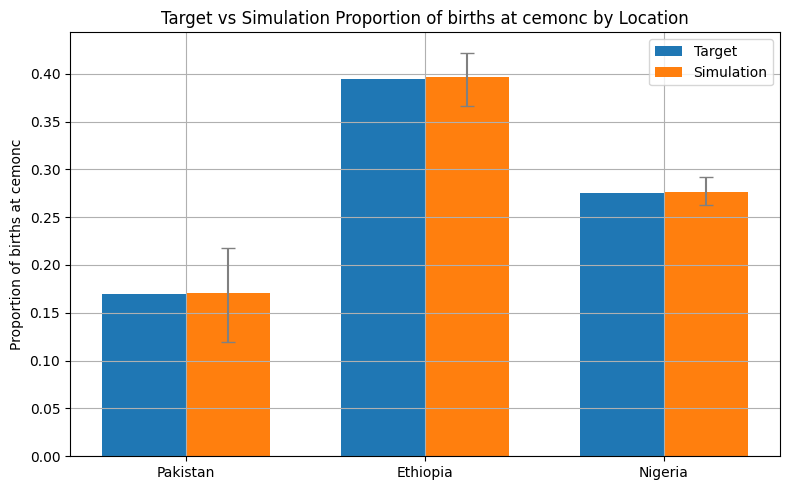

In [27]:
for delivery_facility in ['home','bemonc','cemonc']:
    sim = df.loc[df.delivery_facility_type.str.lower() == delivery_facility].groupby(['input_draw','location'])['value'].sum()
    sim = (sim / df.groupby(['input_draw','location'])['value'].sum()).groupby(['location']).describe(percentiles=[0.025,0.975]).reset_index()
    key = f'cause.facility_choice.probability_{delivery_facility}_birth'
    artifact_delivery_facility = read_artifact(key=key).mean(axis=1).rename('target_value').reset_index()
    plot_data = artifact_delivery_facility.merge(sim, on='location')
    plot_data['probability_of'] = f'Proportion of births at {delivery_facility}'
    plot_proportion_by_location(plot_data)

# The "home" plot is just the inverse of the IFD plot above, so it looks good too
# BEmONC and CEmONC look good
# TODO: Reduce duplication here

**Baseline ANC1 attendance vs GBD covariate ID 7**

In [28]:
baseline_anc = (df.groupby(['input_draw','location','anc1'])['value'].sum()
                / df.groupby(['input_draw','location'])['value'].sum())
baseline_anc = baseline_anc.groupby(['location','anc1']).describe(percentiles=[0.025,0.975]).reset_index()
baseline_anc = baseline_anc.loc[baseline_anc.anc1]
baseline_anc

,location,anc1,count,mean,std,min,2.5%,50%,97.5%,max
1,Ethiopia,True,10.0,0.762900,0.046711,0.702472,0.705864,0.753239,0.839663,0.846368
3,Nigeria,True,10.0,0.735054,0.023425,0.704616,0.706203,0.730992,0.773477,0.776844
5,Pakistan,True,10.0,0.927227,0.000092,0.927067,0.927080,0.927235,0.927350,0.927362


In [29]:
target_anc = return_target_data('anc1')
target_anc

,location,probability_of,target_value
0,Ethiopia,anc1,0.780110
1,Nigeria,anc1,0.742999
2,Pakistan,anc1,0.924081


In [30]:
anc_plot_data = (target_anc
                 .merge(baseline_anc, on='location'))
anc_plot_data


,location,probability_of,target_value,anc1,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,anc1,0.780110,True,10.0,0.762900,0.046711,0.702472,0.705864,0.753239,0.839663,0.846368
1,Nigeria,anc1,0.742999,True,10.0,0.735054,0.023425,0.704616,0.706203,0.730992,0.773477,0.776844
2,Pakistan,anc1,0.924081,True,10.0,0.927227,0.000092,0.927067,0.927080,0.927235,0.927350,0.927362


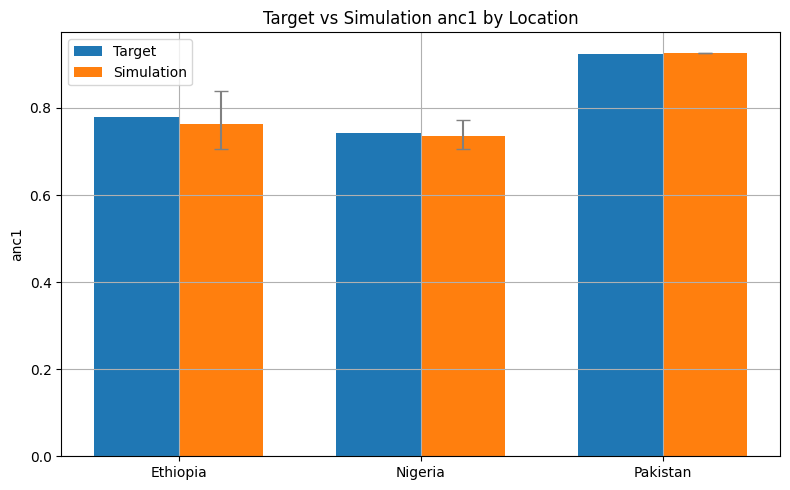

In [31]:
plot_proportion_by_location(anc_plot_data)

# Looks good

In [32]:
art.load('covariate.antenatal_care_first_trimester_visit_coverage_proportion.estimate').apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
# so we have draw-level data for ANC attendance... could this be throwing us off?
# we also have draw-level data for LBWSG exposure/preterm prevalence obviously
# TODO: I don't understand what the above comment means, and we don't appear to be off to me

,,count,mean,std,min,2.5%,50%,97.5%,max
year_start,year_end,,,,,,,,
2023,2024,1000.0,0.432472,0.013389,0.381427,0.406672,0.432829,0.458936,0.472831


**Baseline ultrasound coverage at ANC**

In [33]:
baseline_us = (df.groupby(['input_draw','location','anc1','ultrasound_type'])['value'].sum()
                / df.groupby(['input_draw','location','anc1'])['value'].sum()).reset_index()
assert baseline_us.loc[(baseline_us.anc1 == False) & (baseline_us.ultrasound_type != 'no_ultrasound')]['value'].sum() == 0, "Unexpected ultrasound when no ANC"
assert baseline_us.loc[baseline_us.ultrasound_type == 'AI_assisted']['value'].sum() == 0, "Unexpected presence of AI-assisted ultrasound at baseline"
baseline_us = baseline_us.groupby(['location','anc1','ultrasound_type'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
baseline_us


,location,anc1,ultrasound_type,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,False,AI_assisted,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ethiopia,False,no_ultrasound,10.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Ethiopia,False,standard,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Ethiopia,True,AI_assisted,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Ethiopia,True,no_ultrasound,10.0,0.392448,0.001405,0.390701,0.390793,0.392309,0.394806,0.394920
5,Ethiopia,True,standard,10.0,0.607552,0.001405,0.605080,0.605194,0.607691,0.609207,0.609299
6,Nigeria,False,AI_assisted,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Nigeria,False,no_ultrasound,10.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,Nigeria,False,standard,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Nigeria,True,AI_assisted,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
us_target = return_target_data('standard_ultrasound_given_anc1')
us_target

,location,probability_of,target_value
0,Ethiopia,standard_ultrasound_given_anc1,0.607
1,Nigeria,standard_ultrasound_given_anc1,0.587
2,Pakistan,standard_ultrasound_given_anc1,0.667


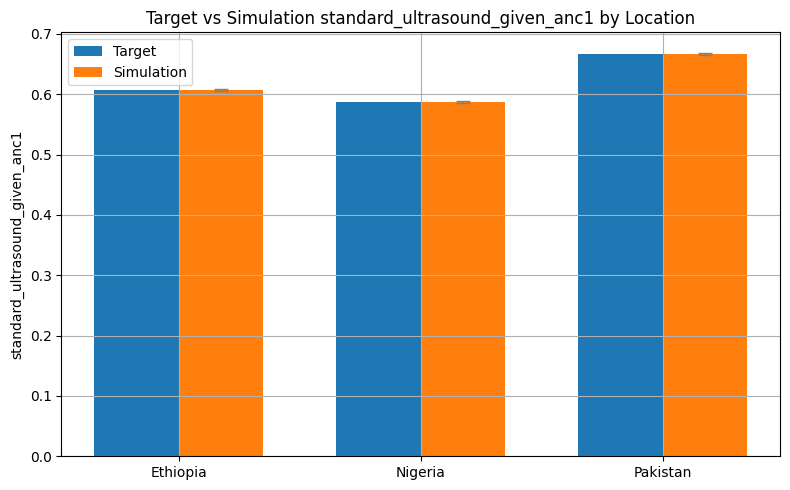

In [35]:
us_plot_data = us_target.merge(baseline_us.loc[baseline_us.anc1 & (baseline_us.ultrasound_type == 'standard')], on='location')
plot_proportion_by_location(us_plot_data)

# Looks good

**Baseline prevalence of preterm birth**

In [36]:
baseline_preterm = (df.groupby(['input_draw','location','preterm_birth'])['value'].sum()
                / df.groupby(['input_draw','location'])['value'].sum())
baseline_preterm = baseline_preterm.groupby(['location','preterm_birth']).describe(percentiles=[0.025,0.975]).reset_index()
baseline_preterm = baseline_preterm.loc[baseline_preterm.preterm_birth]
baseline_preterm

# this has very small levels of variation by draw which is suprising to me
# TODO: understand this

,location,preterm_birth,count,mean,std,min,2.5%,50%,97.5%,max
1,Ethiopia,True,10.0,0.171753,0.001878,0.168475,0.168769,0.171917,0.174182,0.174405
3,Nigeria,True,10.0,0.169748,0.001099,0.167641,0.167728,0.170382,0.170602,0.170615
5,Pakistan,True,10.0,0.169727,0.003550,0.164800,0.164801,0.170196,0.175921,0.177329


In [37]:
preterm_target = return_target_data('preterm')
preterm_target

,location,probability_of,target_value
0,Ethiopia,preterm,0.163527
1,Nigeria,preterm,0.162567
2,Pakistan,preterm,0.163933


In [38]:
# TODO: Use `keys` variable
[x for x in art.keys if 'preterm' in x]

['cause.neonatal_preterm_birth.population_attributable_fraction',
 'cause.neonatal_preterm_birth.prevalence',
 'cause.neonatal_preterm_birth.mortality_risk',
 'cause.neonatal_preterm_birth.adjusted_birth_counts',
 'cause.facility_choice.probability_home_birth_given_preterm']

In [39]:
art.load('cause.neonatal_preterm_birth.prevalence')[[f'draw_{draw}' for draw in draws]].mean(axis=1).groupby('child_age_start').mean()

# This is very similar to the target value, but not identical -- PAF sim stochastic uncertainty?

child_age_start
0.000000    0.163869
0.019178    0.155241
dtype: float64

In [40]:
preterm_plot_data = preterm_target.merge(baseline_preterm, on=['location'])
preterm_plot_data

,location,probability_of,target_value,preterm_birth,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,preterm,0.163527,True,10.0,0.171753,0.001878,0.168475,0.168769,0.171917,0.174182,0.174405
1,Nigeria,preterm,0.162567,True,10.0,0.169748,0.001099,0.167641,0.167728,0.170382,0.170602,0.170615
2,Pakistan,preterm,0.163933,True,10.0,0.169727,0.003550,0.164800,0.164801,0.170196,0.175921,0.177329


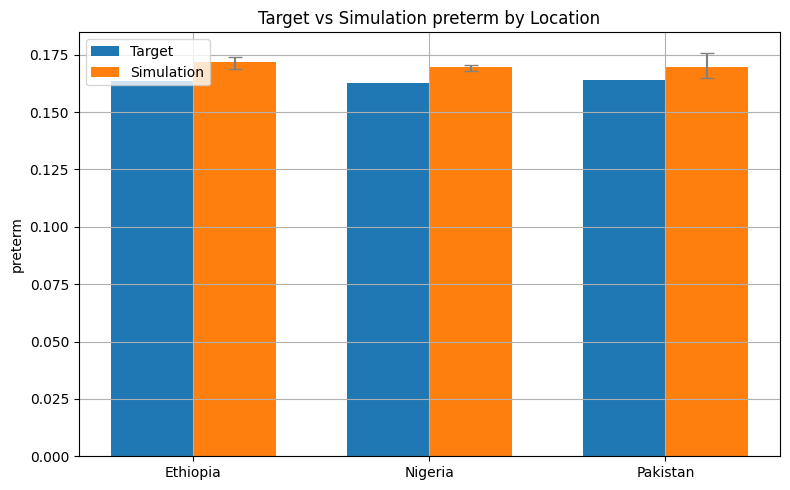

In [41]:
plot_proportion_by_location(preterm_plot_data)

# Looks good, or at least very close

**Live birth ratio in simulation vs. GBD covariate ID 1106**

In [42]:
baseline_sex_ratio = (births_df.loc[births_df.pregnancy_outcome=='live_birth']
                      .groupby(['input_draw','location','child_sex'])['value'].sum()
                      / births_df.loc[births_df.pregnancy_outcome=='live_birth']
                      .groupby(['input_draw','location'])['value'].sum())
baseline_sex_ratio = baseline_sex_ratio.groupby(['location','child_sex']).describe(percentiles=[0.025,0.975]).reset_index()
baseline_sex_ratio

,location,child_sex,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,Female,10.0,0.484870,0.000914,0.483957,0.483966,0.484731,0.486604,0.486795
1,Ethiopia,Male,10.0,0.515130,0.000914,0.513205,0.513396,0.515269,0.516034,0.516043
2,Nigeria,Female,10.0,0.486931,0.000993,0.485543,0.485686,0.486636,0.488531,0.488700
3,Nigeria,Male,10.0,0.513069,0.000993,0.511300,0.511469,0.513364,0.514314,0.514457
4,Pakistan,Female,10.0,0.479805,0.001099,0.477633,0.477958,0.479701,0.481290,0.481421
5,Pakistan,Male,10.0,0.520195,0.001099,0.518579,0.518710,0.520299,0.522042,0.522367


In [43]:
target_sex_ratio = return_target_data('male')

In [44]:
sex_ratio_plot_data = target_sex_ratio.merge(baseline_sex_ratio.loc[baseline_sex_ratio.child_sex=='Male'], on=['location'])
sex_ratio_plot_data

,location,probability_of,target_value,child_sex,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,male,0.515312,Male,10.0,0.515130,0.000914,0.513205,0.513396,0.515269,0.516034,0.516043
1,Nigeria,male,0.512450,Male,10.0,0.513069,0.000993,0.511300,0.511469,0.513364,0.514314,0.514457
2,Pakistan,male,0.519811,Male,10.0,0.520195,0.001099,0.518579,0.518710,0.520299,0.522042,0.522367


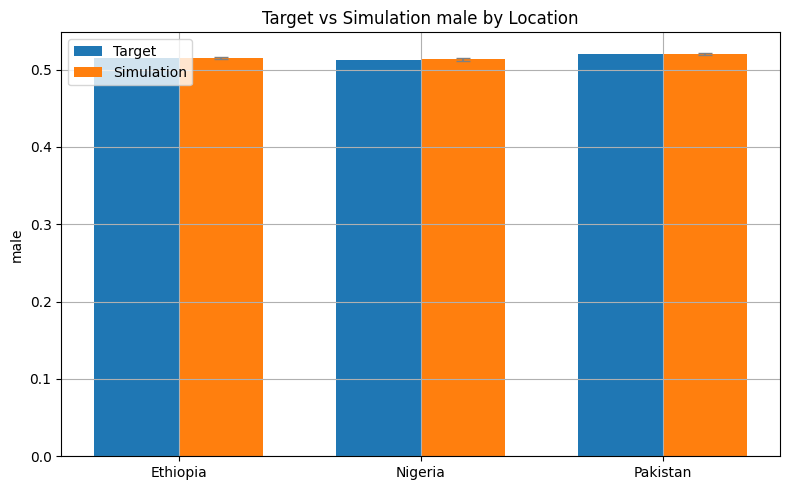

In [45]:
plot_proportion_by_location(sex_ratio_plot_data)

# Looks good

## Bivariate checks

**Check 1:** Validate rates of preterm birth given in-facility status against optimization targets (calculated in facility choice validation targets notebook: https://github.com/ihmeuw/vivarium_research_mncnh_portfolio/blob/main/facility_choice/facility_choice_validation_targets.ipynb)

In [46]:
target_preterm_given_home = return_target_data('preterm_given_at_home')
target_preterm_given_facility = return_target_data('preterm_given_in_facility')

target_preterm_given_home

,location,probability_of,target_value
0,Ethiopia,preterm_given_at_home,0.163579
1,Nigeria,preterm_given_at_home,0.172663
2,Pakistan,preterm_given_at_home,0.194529


In [47]:
# TODO: extract the logic here with `cols` into a function
cols = ['input_draw','location','ifd']
delivery_facility_by_preterm = (df.groupby(cols + ['preterm_birth'])['value'].sum() 
                            / df.groupby(cols)['value'].sum()).reset_index()
delivery_facility_by_preterm = delivery_facility_by_preterm.loc[delivery_facility_by_preterm.preterm_birth]
delivery_facility_by_preterm = delivery_facility_by_preterm.groupby([x for x in cols if x != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
delivery_facility_by_preterm

,location,ifd,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,False,10.0,0.168109,0.002484,0.163464,0.163736,0.168370,0.171520,0.172065
1,Ethiopia,True,10.0,0.174590,0.002219,0.171159,0.171226,0.175442,0.177189,0.177433
2,Nigeria,False,10.0,0.181525,0.000925,0.179975,0.180102,0.181741,0.182717,0.182770
3,Nigeria,True,10.0,0.158720,0.001584,0.155569,0.155855,0.159237,0.160717,0.160921
4,Pakistan,False,10.0,0.202110,0.004256,0.196434,0.196469,0.201703,0.209937,0.211472
5,Pakistan,True,10.0,0.160662,0.003396,0.155896,0.155900,0.161284,0.166548,0.167787


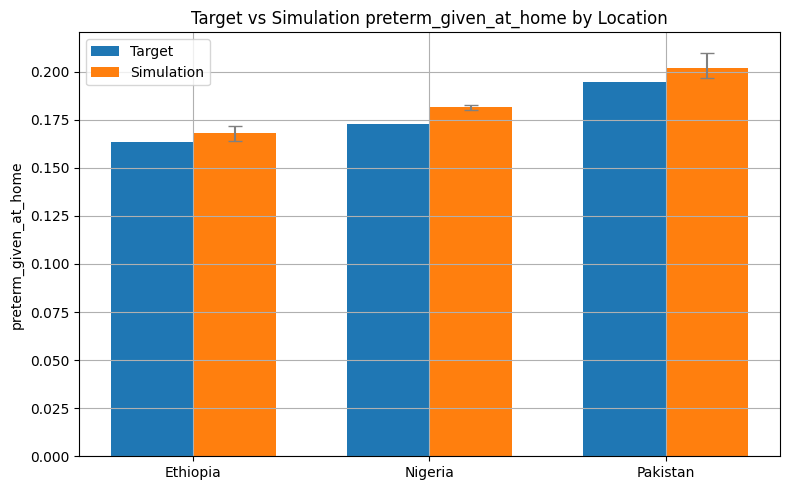

In [48]:
plot_proportion_by_location(target_preterm_given_home
                            .merge(delivery_facility_by_preterm.loc[delivery_facility_by_preterm.ifd==False], on='location'))

# Looks pretty close, maybe a bit low in Ethiopia and high in Nigeria?

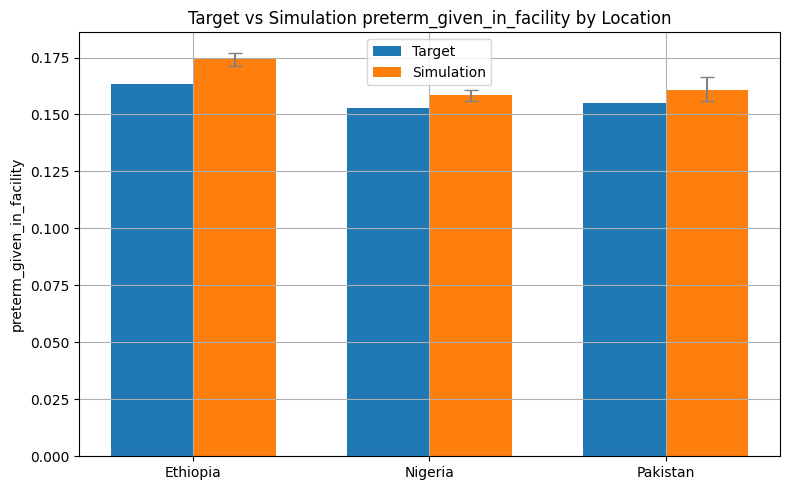

In [49]:
plot_proportion_by_location(target_preterm_given_facility
                            .merge(delivery_facility_by_preterm.loc[delivery_facility_by_preterm.ifd==True], on='location'))

# Looks good, maybe a bit high

**Check 2:** Validate rates of in-facility delivery given ANC status against optimization targets 

In [50]:
cols = ['input_draw','location','anc1']
delivery_facility_by_anc = (df.groupby(cols + ['ifd'])['value'].sum() 
                            / df.groupby(cols)['value'].sum()).reset_index()
delivery_facility_by_anc = delivery_facility_by_anc.loc[delivery_facility_by_anc.ifd].drop(columns='ifd')
delivery_facility_by_anc = delivery_facility_by_anc.groupby([x for x in cols if x != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
delivery_facility_by_anc

,location,anc1,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,False,10.0,0.193665,0.030411,0.135237,0.140577,0.199827,0.228233,0.229860
1,Ethiopia,True,10.0,0.676216,0.020594,0.639393,0.642559,0.680979,0.701858,0.703887
2,Nigeria,False,10.0,0.319513,0.006798,0.308219,0.308957,0.321234,0.327686,0.328328
3,Nigeria,True,10.0,0.587380,0.005156,0.578712,0.579121,0.588615,0.594157,0.594661
4,Pakistan,False,10.0,0.567103,0.001589,0.564743,0.564970,0.567015,0.569943,0.570248
5,Pakistan,True,10.0,0.798096,0.000312,0.797546,0.797615,0.798090,0.798642,0.798747


In [51]:
targets.loc[targets.probability_of.isin(['anc1','in_facility'])]

,probability_of,Ethiopia,Nigeria,Pakistan
7,anc1,0.780110,0.742999,0.924081
11,in_facility,0.558927,0.513467,0.777256


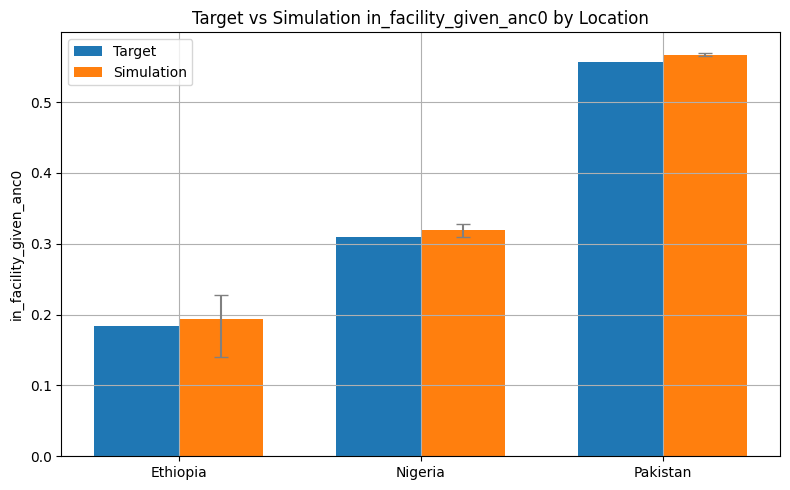

In [52]:
plot = return_target_data('in_facility_given_anc0').merge(delivery_facility_by_anc.loc[delivery_facility_by_anc.anc1==False], on='location')
plot_proportion_by_location(plot)

# Looks good, maybe a bit high

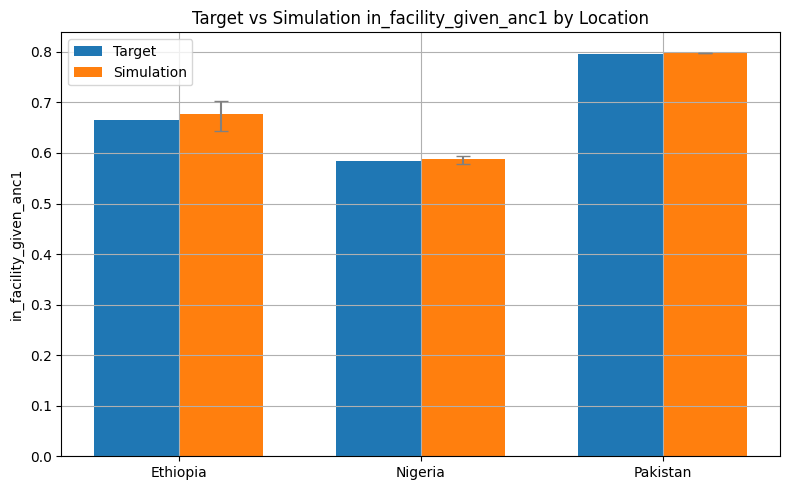

In [53]:
plot = return_target_data('in_facility_given_anc1').merge(delivery_facility_by_anc.loc[delivery_facility_by_anc.anc1], on='location')
plot_proportion_by_location(plot)

# Looks good

**Check #3:** Validate observed probabilities of IFD given believed preterm status against observed probabilities in facility choice nanosim: (https://github.com/ihmeuw/vivarium_research_mncnh_portfolio/blob/main/facility_choice/facility_choice_validation_targets.ipynb)

In [54]:
cols = ['input_draw','location','believed_preterm']
delivery_facility_by_believed_preterm = (df.groupby(cols + ['ifd'])['value'].sum() 
                            / df.groupby(cols)['value'].sum()).reset_index()
delivery_facility_by_believed_preterm = delivery_facility_by_believed_preterm.loc[delivery_facility_by_believed_preterm.ifd == False]
delivery_facility_by_believed_preterm = delivery_facility_by_believed_preterm.groupby([x for x in cols if x != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
delivery_facility_by_believed_preterm

,location,believed_preterm,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,False,10.0,0.461090,0.000812,0.459717,0.459894,0.460863,0.462352,0.462441
1,Ethiopia,True,10.0,0.372948,0.002695,0.369635,0.369856,0.372305,0.377870,0.378337
2,Nigeria,False,10.0,0.493248,0.001305,0.491302,0.491442,0.493159,0.495141,0.495226
3,Nigeria,True,10.0,0.456374,0.002444,0.452674,0.452735,0.457278,0.459427,0.459732
4,Pakistan,False,10.0,0.218649,0.000509,0.217875,0.217956,0.218616,0.219530,0.219592
5,Pakistan,True,10.0,0.218896,0.000788,0.217301,0.217541,0.218819,0.219981,0.220015


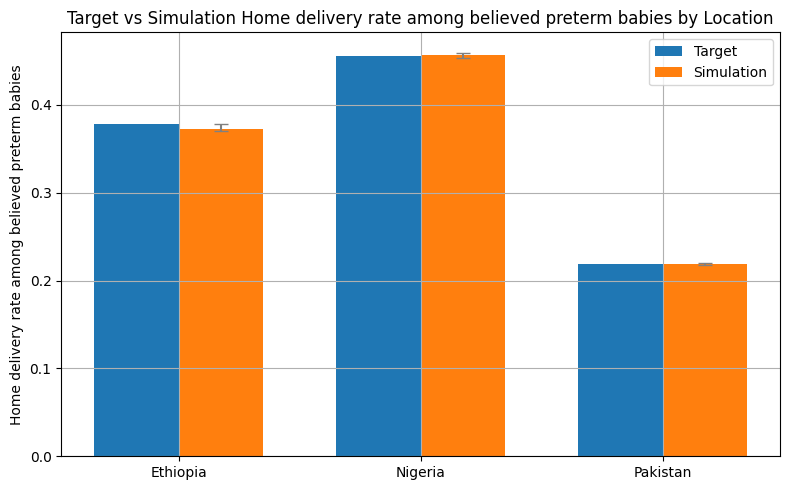

In [55]:
p_home_believed_preterm = return_target_data('at_home_given_believed_preterm')
plot = p_home_believed_preterm.merge(delivery_facility_by_believed_preterm.loc[delivery_facility_by_believed_preterm.believed_preterm==True], 
                                     on=['location'])
plot['probability_of'] = 'Home delivery rate among believed preterm babies'
plot_proportion_by_location(plot)

# Looks good

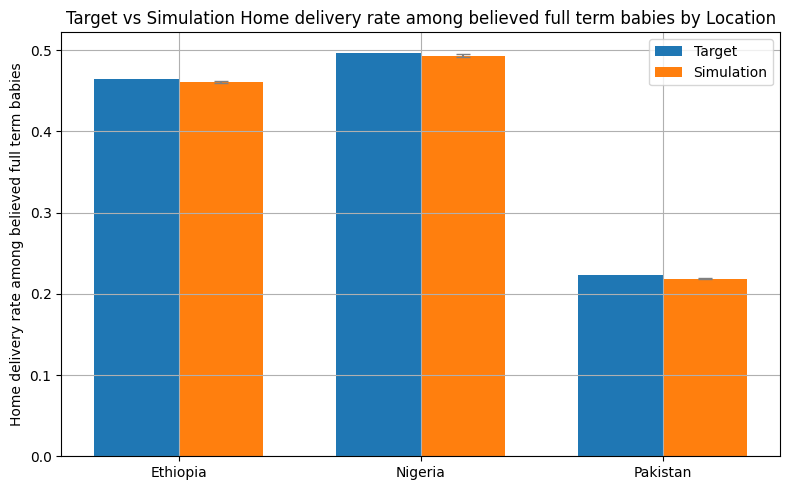

In [56]:
p_home_believed_term = return_target_data('at_home_given_believed_term')
plot = p_home_believed_term.merge(delivery_facility_by_believed_preterm.loc[delivery_facility_by_believed_preterm.believed_preterm==False].rename(columns={'value':'mean'}), 
                                     on=['location'])
plot['probability_of'] = 'Home delivery rate among believed full term babies'
plot_proportion_by_location(plot)

# Looks good

**Check 4:** Validate confusion matrix of preterm status vs. believed preterm status against observed probabilities in facility choice nanosim (https://github.com/ihmeuw/vivarium_research_mncnh_portfolio/blob/main/facility_choice/facility_choice_validation_targets.ipynb)

In [57]:
confusion = (df.groupby(['location','input_draw','preterm_birth','believed_preterm'])['value'].sum()
             / df.groupby(['location','input_draw','preterm_birth'])['value'].sum())
confusion = confusion.groupby(['location','preterm_birth','believed_preterm']).describe(percentiles=[0.025,0.975]).reset_index()
confusion

,location,preterm_birth,believed_preterm,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,False,False,10.0,0.861384,0.001641,0.859720,0.859736,0.860960,0.864305,0.864632
1,Ethiopia,False,True,10.0,0.138616,0.001641,0.135368,0.135695,0.139040,0.140264,0.140280
2,Ethiopia,True,False,10.0,0.129183,0.004281,0.124220,0.124423,0.127322,0.135763,0.136425
3,Ethiopia,True,True,10.0,0.870817,0.004281,0.863575,0.864237,0.872678,0.875577,0.875780
4,Nigeria,False,False,10.0,0.862934,0.001782,0.860823,0.860887,0.862513,0.866274,0.866918
5,Nigeria,False,True,10.0,0.137066,0.001782,0.133082,0.133726,0.137487,0.139113,0.139177
6,Nigeria,True,False,10.0,0.122277,0.004151,0.117251,0.117316,0.121597,0.128497,0.128996
7,Nigeria,True,True,10.0,0.877723,0.004151,0.871004,0.871503,0.878403,0.882684,0.882749
8,Pakistan,False,False,10.0,0.871905,0.001111,0.870438,0.870458,0.871970,0.873815,0.874164
9,Pakistan,False,True,10.0,0.128095,0.001111,0.125836,0.126185,0.128030,0.129542,0.129562


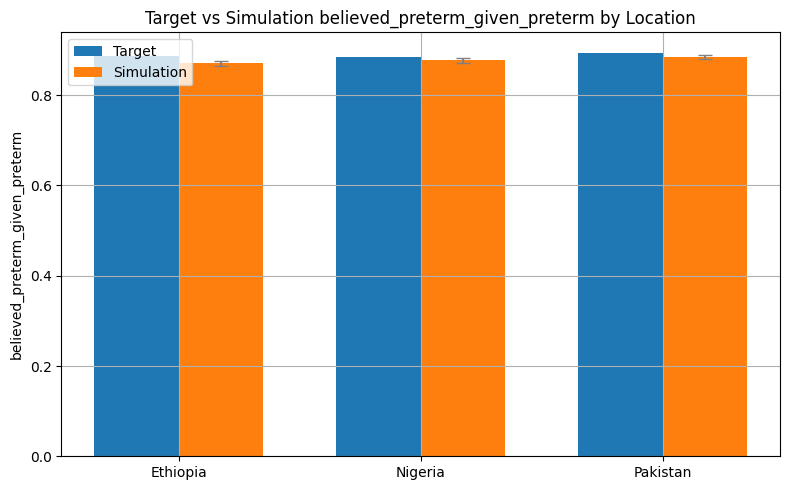

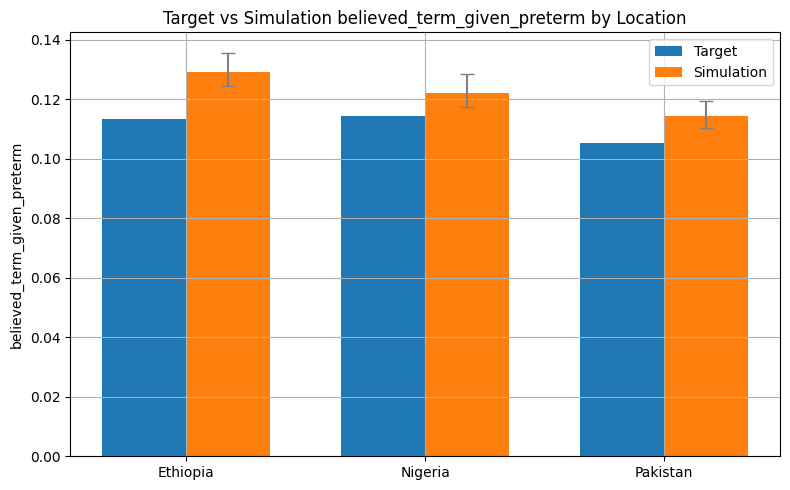

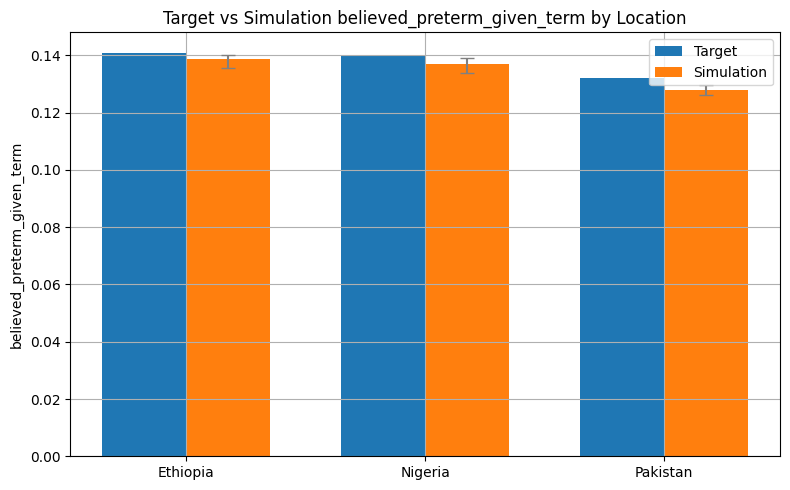

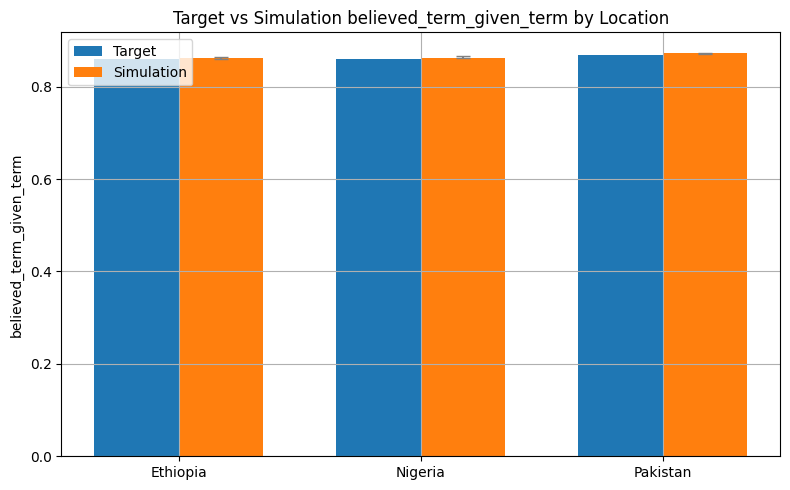

In [58]:
for preterm_birth in [True, False]:
    if preterm_birth:
        true_val = 'preterm'
    else:
        true_val = 'term'
    for believed_preterm_birth in [True, False]:
        if believed_preterm_birth:
            believed_val = 'preterm'
        else:
            believed_val = 'term'
        target_title = f'believed_{believed_val}_given_{true_val}'
        target_data = return_target_data(target_title)
        plot_data = (target_data.merge(confusion.loc[(confusion.preterm_birth == preterm_birth) 
                                                     & (confusion.believed_preterm == believed_preterm_birth)], on='location'))
        plot_proportion_by_location(plot_data)

# Looks good

**Check 5:** Validate P( believed preterm | preterm status, ultrasound type ) against observed probabilities in facility choice nanosim (https://github.com/ihmeuw/vivarium_research_mncnh_portfolio/blob/main/facility_choice/facility_choice_validation_targets.ipynb)

In [59]:
check5 = (df.groupby(['location','input_draw','ultrasound_type','preterm_birth','believed_preterm'])['value'].sum()
             / df.groupby(['location','input_draw','ultrasound_type','preterm_birth'])['value'].sum())
check5 = check5.groupby(['location','ultrasound_type','preterm_birth','believed_preterm']).describe(percentiles=[0.025,0.975]).reset_index()
check5['ultrasound_type'] = np.where(check5.ultrasound_type == 'standard', 'standard_ultrasound', check5.ultrasound_type)
check5

,location,ultrasound_type,preterm_birth,believed_preterm,count,mean,std,min,2.5%,50%,97.5%,max
0,Ethiopia,AI_assisted,False,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ethiopia,AI_assisted,False,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ethiopia,AI_assisted,True,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ethiopia,AI_assisted,True,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ethiopia,no_ultrasound,False,False,10.0,0.833187,0.001580,0.831400,0.831517,0.832923,0.836376,0.836957
5,Ethiopia,no_ultrasound,False,True,10.0,0.166813,0.001580,0.163043,0.163624,0.167077,0.168483,0.168600
6,Ethiopia,no_ultrasound,True,False,10.0,0.141370,0.003812,0.136733,0.136757,0.139805,0.146677,0.146883
7,Ethiopia,no_ultrasound,True,True,10.0,0.858630,0.003812,0.853117,0.853323,0.860195,0.863243,0.863267
8,Ethiopia,standard_ultrasound,False,False,10.0,0.892349,0.001495,0.889851,0.890084,0.892339,0.894904,0.895293
9,Ethiopia,standard_ultrasound,False,True,10.0,0.107651,0.001495,0.104707,0.105096,0.107661,0.109916,0.110149


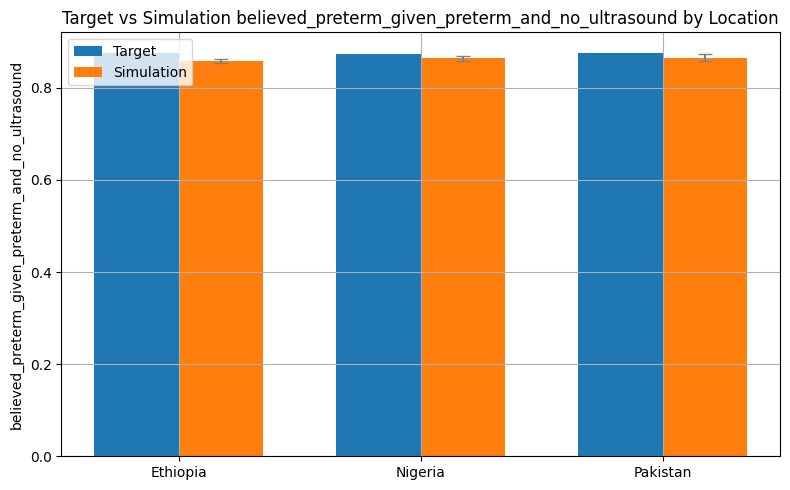

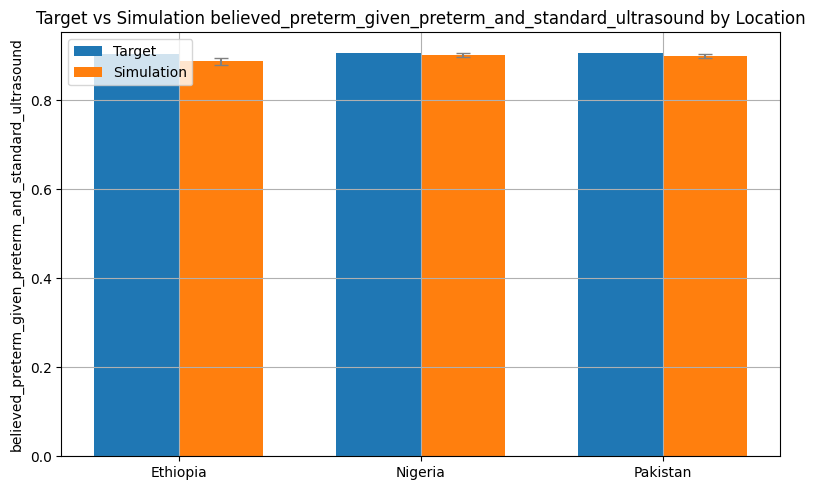

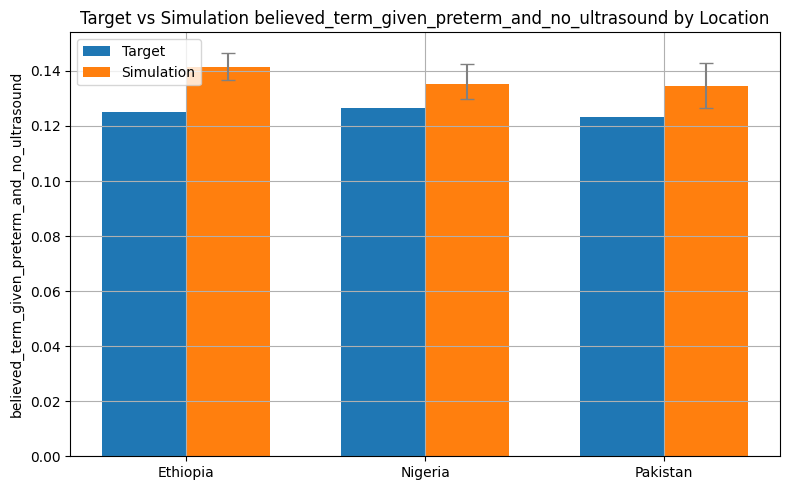

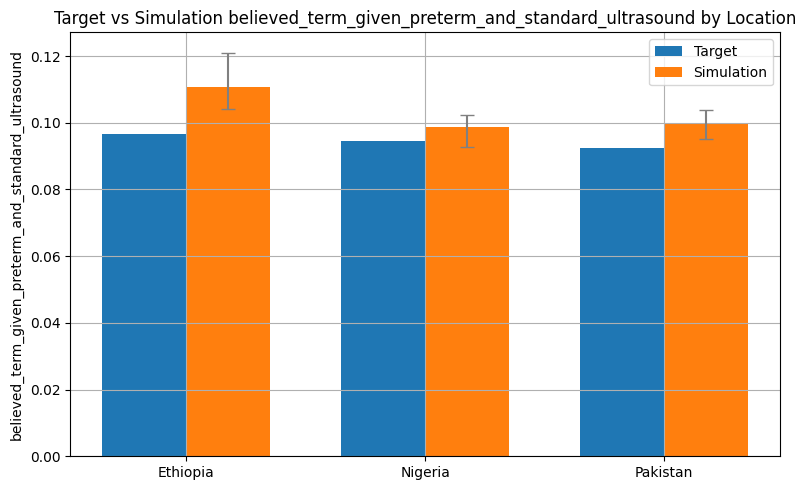

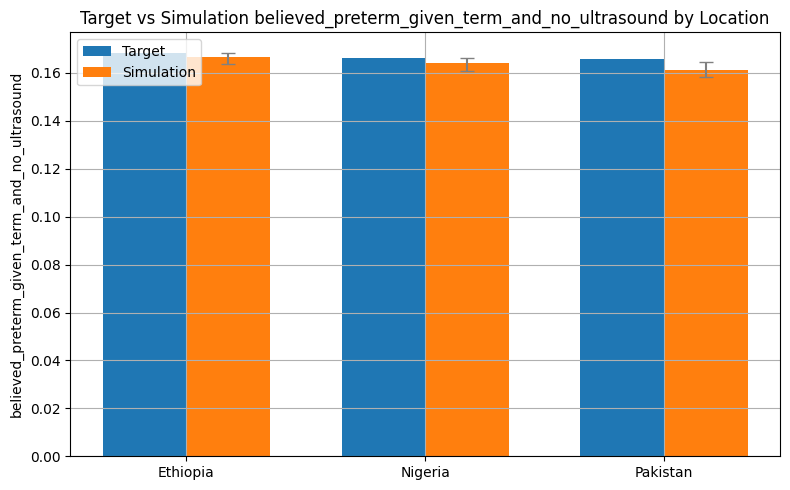

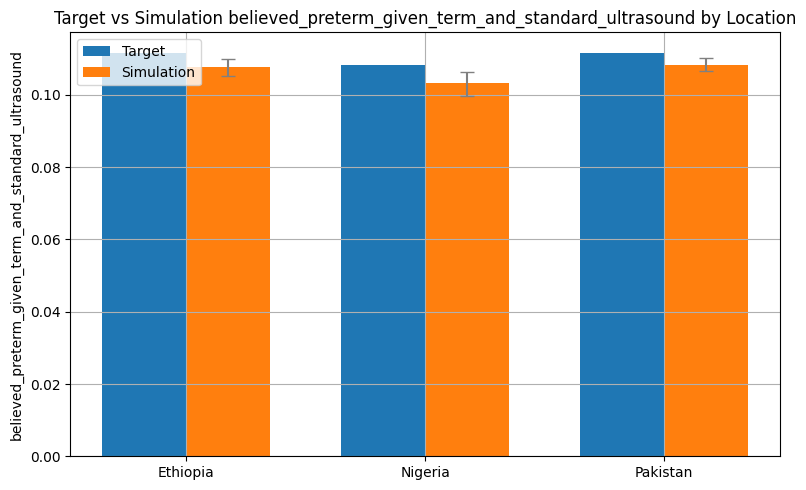

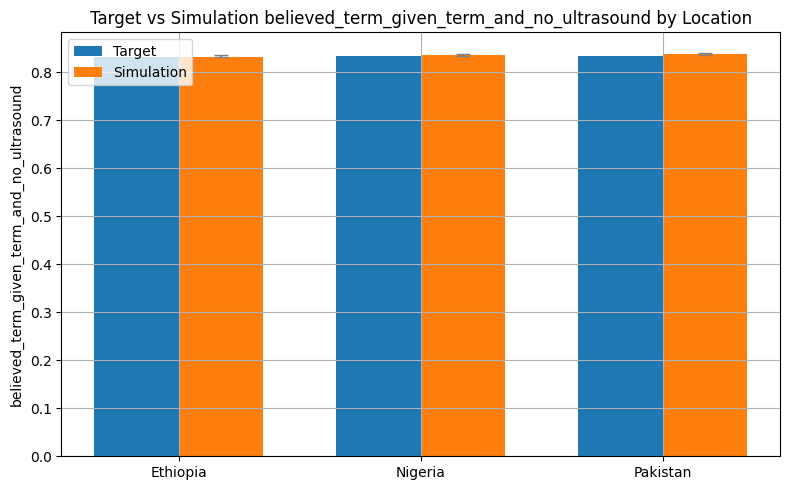

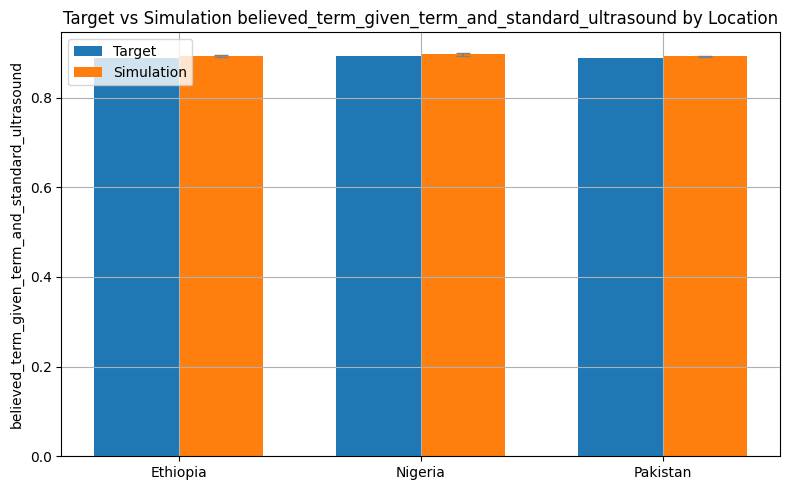

In [60]:
for preterm_birth in [True, False]:
    if preterm_birth:
        true_val = 'preterm'
    else:
        true_val = 'term'
    for believed_preterm_birth in [True, False]:
        if believed_preterm_birth:
            believed_val = 'preterm'
        else:
            believed_val = 'term'
        for ultrasound_type in ['no_ultrasound', 'standard_ultrasound']:
            target_title = f'believed_{believed_val}_given_{true_val}_and_{ultrasound_type}'
            target_data = return_target_data(target_title)
            plot_data = (target_data.merge(check5.loc[(check5.preterm_birth == preterm_birth) 
                                                        & (check5.believed_preterm == believed_preterm_birth)
                                                        & (check5.ultrasound_type == ultrasound_type)], on='location'))
            plot_proportion_by_location(plot_data)